# EDA: Signal Quality Analysis
Analyze signal quality for OSAS detection dataset
- ECG/PPG/PSG waveform completeness
- NaN rate per signal
- Identify noisy patients

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy import signal as scipy_signal
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## Load Dataset

In [ ]:
# Load the dataset
try:
    dataset = pd.read_pickle('./data/dataset_OSAS.pickle')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Dataset file not found...")

print(f"Dataset shape: {dataset.shape}")
print(f"Unique patients: {dataset['patient'].nunique()}")

Dataset loaded successfully!
Dataset shape: (961357, 18)
Unique patients: 30


## 1. Signal Completeness Analysis

In [3]:
# Define signal columns based on the dataset structure
vital_columns = ['HR(bpm)', 'SpO2(%)', 'PI(%)', 'RR(rpm)', 'PVCs(/min)']
waveform_columns = ['signal_ecg_i', 'signal_ecg_ii', 'signal_ecg_iii', 'signal_pleth']
psg_columns = ['PSG_Flow', 'PSG_Snore', 'PSG_Position', 'PSG_Thorax', 'PSG_Abdomen']

# Filter columns that actually exist in the dataset
available_vitals = [col for col in vital_columns if col in dataset.columns]
available_waveforms = [col for col in waveform_columns if col in dataset.columns]
available_psg = [col for col in psg_columns if col in dataset.columns]

all_signal_columns = available_vitals + available_waveforms + available_psg

print("Available signal columns:")
print(f"  Vitals: {available_vitals}")
print(f"  Waveforms: {available_waveforms}")
print(f"  PSG: {available_psg}")

Available signal columns:
  Vitals: ['HR(bpm)', 'SpO2(%)', 'PI(%)', 'RR(rpm)', 'PVCs(/min)']
  Waveforms: ['signal_ecg_i', 'signal_ecg_ii', 'signal_ecg_iii', 'signal_pleth']
  PSG: ['PSG_Flow', 'PSG_Snore', 'PSG_Position', 'PSG_Thorax', 'PSG_Abdomen']


In [4]:
# Calculate missing data rates for different signal types
def calculate_signal_missing_rate(series):
    """Calculate missing rate for signal data (handles both scalar and array data)"""
    if len(series) == 0:
        return 0
    
    missing_count = 0
    total_count = len(series)
    
    for value in series:
        try:
            # First check if the value itself is None or a scalar NaN
            if value is None:
                missing_count += 1
                continue
                
            # Check if it's a scalar value
            if np.isscalar(value):
                if pd.isna(value):
                    missing_count += 1
            # Check if it's array-like (waveforms)
            elif hasattr(value, '__len__') and not isinstance(value, str):
                try:
                    value_array = np.array(value)
                    # Check if all values in the array are NaN
                    if len(value_array) == 0 or np.all(pd.isna(value_array)):
                        missing_count += 1
                except (TypeError, ValueError):
                    # If we can't process it, assume it's valid data
                    pass
            # For other types, assume they're valid
            
        except Exception:
            # If any error occurs, assume it's valid data
            pass
    
    return (missing_count / total_count) * 100

# Calculate missing rates
missing_rates = {}
for col in all_signal_columns:
    if col in dataset.columns:
        missing_rates[col] = calculate_signal_missing_rate(dataset[col])

missing_df = pd.DataFrame(list(missing_rates.items()), columns=['Signal', 'Missing_Rate_%'])
missing_df = missing_df.sort_values('Missing_Rate_%', ascending=False)

print("SIGNAL COMPLETENESS ANALYSIS:")
print("=" * 40)
print(missing_df)

# Categorize signals by quality
high_quality = missing_df[missing_df['Missing_Rate_%'] < 5]
medium_quality = missing_df[(missing_df['Missing_Rate_%'] >= 5) & (missing_df['Missing_Rate_%'] < 15)]
low_quality = missing_df[missing_df['Missing_Rate_%'] >= 15]

print(f"\nSIGNAL QUALITY CATEGORIES:")
print(f"High Quality (< 5% missing): {len(high_quality)} signals")
print(f"Medium Quality (5-15% missing): {len(medium_quality)} signals")
print(f"Low Quality (> 15% missing): {len(low_quality)} signals")

SIGNAL COMPLETENESS ANALYSIS:
            Signal  Missing_Rate_%
2            PI(%)       13.861136
1          SpO2(%)       13.790923
8     signal_pleth       13.554694
7   signal_ecg_iii        3.158348
3          RR(rpm)        1.919786
6    signal_ecg_ii        0.715239
5     signal_ecg_i        0.375719
0          HR(bpm)        0.368646
4       PVCs(/min)        0.368646
9         PSG_Flow        0.000000
10       PSG_Snore        0.000000
11    PSG_Position        0.000000
12      PSG_Thorax        0.000000
13     PSG_Abdomen        0.000000

SIGNAL QUALITY CATEGORIES:
High Quality (< 5% missing): 11 signals
Medium Quality (5-15% missing): 3 signals
Low Quality (> 15% missing): 0 signals


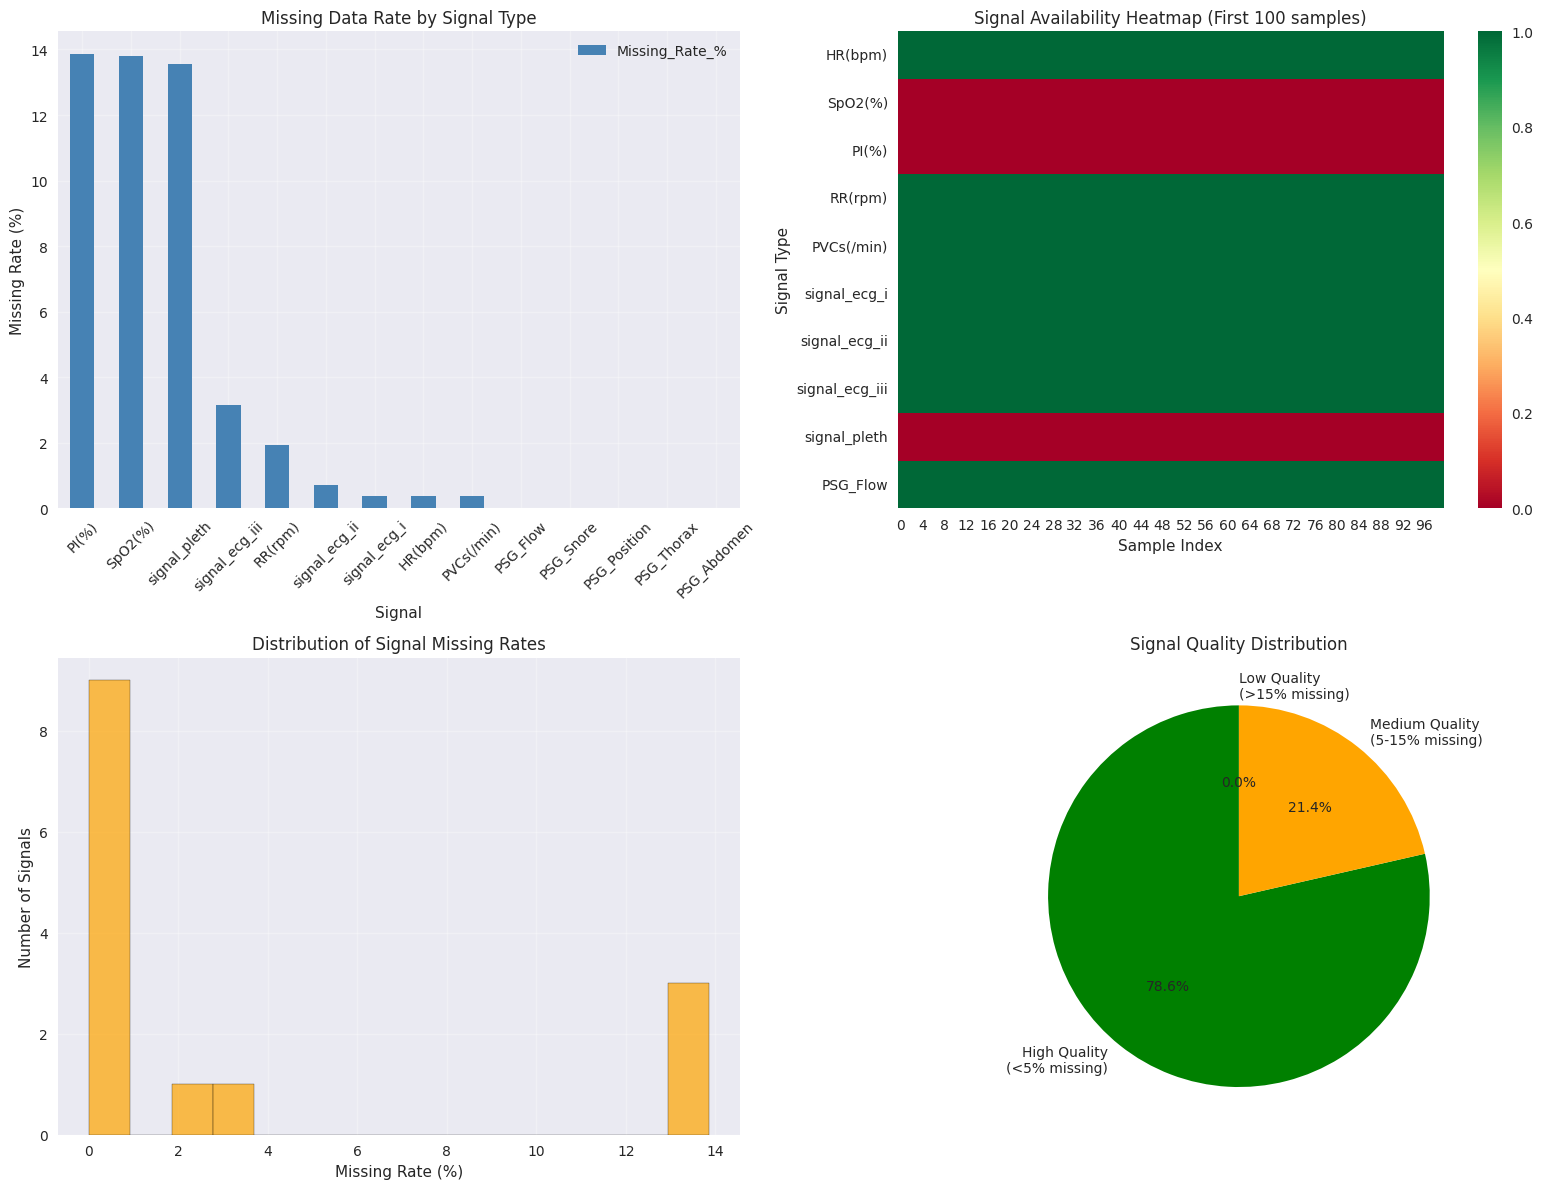

In [5]:
# Visualize signal completeness
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Bar plot of missing rates
missing_df.plot(x='Signal', y='Missing_Rate_%', kind='bar', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Missing Data Rate by Signal Type')
axes[0,0].set_ylabel('Missing Rate (%)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Heatmap showing signal availability
def check_signal_availability(x):
    """Check if a signal value is available (not missing)"""
    try:
        # First check if the value itself is None
        if x is None:
            return 0
            
        # Check if it's a scalar value
        if np.isscalar(x):
            return 0 if pd.isna(x) else 1
        # Check if it's array-like (waveforms)
        elif hasattr(x, '__len__') and not isinstance(x, str):
            try:
                x_array = np.array(x)
                # Check if all values in the array are NaN
                if len(x_array) == 0 or np.all(pd.isna(x_array)):
                    return 0
                else:
                    return 1
            except (TypeError, ValueError):
                # If we can't process it, assume it's valid data
                return 1
        else:
            # For other types, assume they're valid
            return 1
    except Exception:
        # If any error occurs, assume it's valid data
        return 1

signal_availability = pd.DataFrame(index=range(min(100, len(dataset))))
for col in all_signal_columns[:10]:  # Limit to first 10 signals for visibility
    if col in dataset.columns:
        signal_availability[col] = dataset[col].head(100).apply(check_signal_availability)

sns.heatmap(signal_availability.T, cmap='RdYlGn', cbar=True, ax=axes[0,1])
axes[0,1].set_title('Signal Availability Heatmap (First 100 samples)')
axes[0,1].set_xlabel('Sample Index')
axes[0,1].set_ylabel('Signal Type')

# Distribution of missing rates
axes[1,0].hist(missing_df['Missing_Rate_%'], bins=15, alpha=0.7, edgecolor='black', color='orange')
axes[1,0].set_title('Distribution of Signal Missing Rates')
axes[1,0].set_xlabel('Missing Rate (%)')
axes[1,0].set_ylabel('Number of Signals')
axes[1,0].grid(True, alpha=0.3)

# Signal quality by category
quality_counts = [len(high_quality), len(medium_quality), len(low_quality)]
quality_labels = ['High Quality\n(<5% missing)', 'Medium Quality\n(5-15% missing)', 'Low Quality\n(>15% missing)']
colors = ['green', 'orange', 'red']

axes[1,1].pie(quality_counts, labels=quality_labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Signal Quality Distribution')

plt.tight_layout()
plt.show()

## 2. Patient-wise Signal Quality

In [6]:
# Calculate missing rates per patient
patient_signal_quality = {}

for patient_id in dataset['patient'].unique():
    patient_data = dataset[dataset['patient'] == patient_id]
    patient_missing = {}
    
    for col in all_signal_columns:
        if col in patient_data.columns:
            patient_missing[col] = calculate_signal_missing_rate(patient_data[col])
    
    patient_signal_quality[patient_id] = patient_missing

# Convert to DataFrame
patient_quality_df = pd.DataFrame(patient_signal_quality).T
patient_quality_df = patient_quality_df.fillna(0)

# Calculate overall quality score per patient (average missing rate across all signals)
patient_quality_df['overall_missing_rate'] = patient_quality_df.mean(axis=1)
patient_quality_df = patient_quality_df.sort_values('overall_missing_rate')

print("PATIENT-WISE SIGNAL QUALITY:")
print("=" * 40)
print(f"Best quality patients (lowest missing rates):")
print(patient_quality_df['overall_missing_rate'].head(5))
print(f"\nWorst quality patients (highest missing rates):")
print(patient_quality_df['overall_missing_rate'].tail(5))

PATIENT-WISE SIGNAL QUALITY:
Best quality patients (lowest missing rates):
21    0.063199
30    0.077563
12    0.109704
3     0.233070
4     0.365533
Name: overall_missing_rate, dtype: float64

Worst quality patients (highest missing rates):
22     5.647278
10     6.300843
18     7.975709
17    14.096960
28    15.576457
Name: overall_missing_rate, dtype: float64


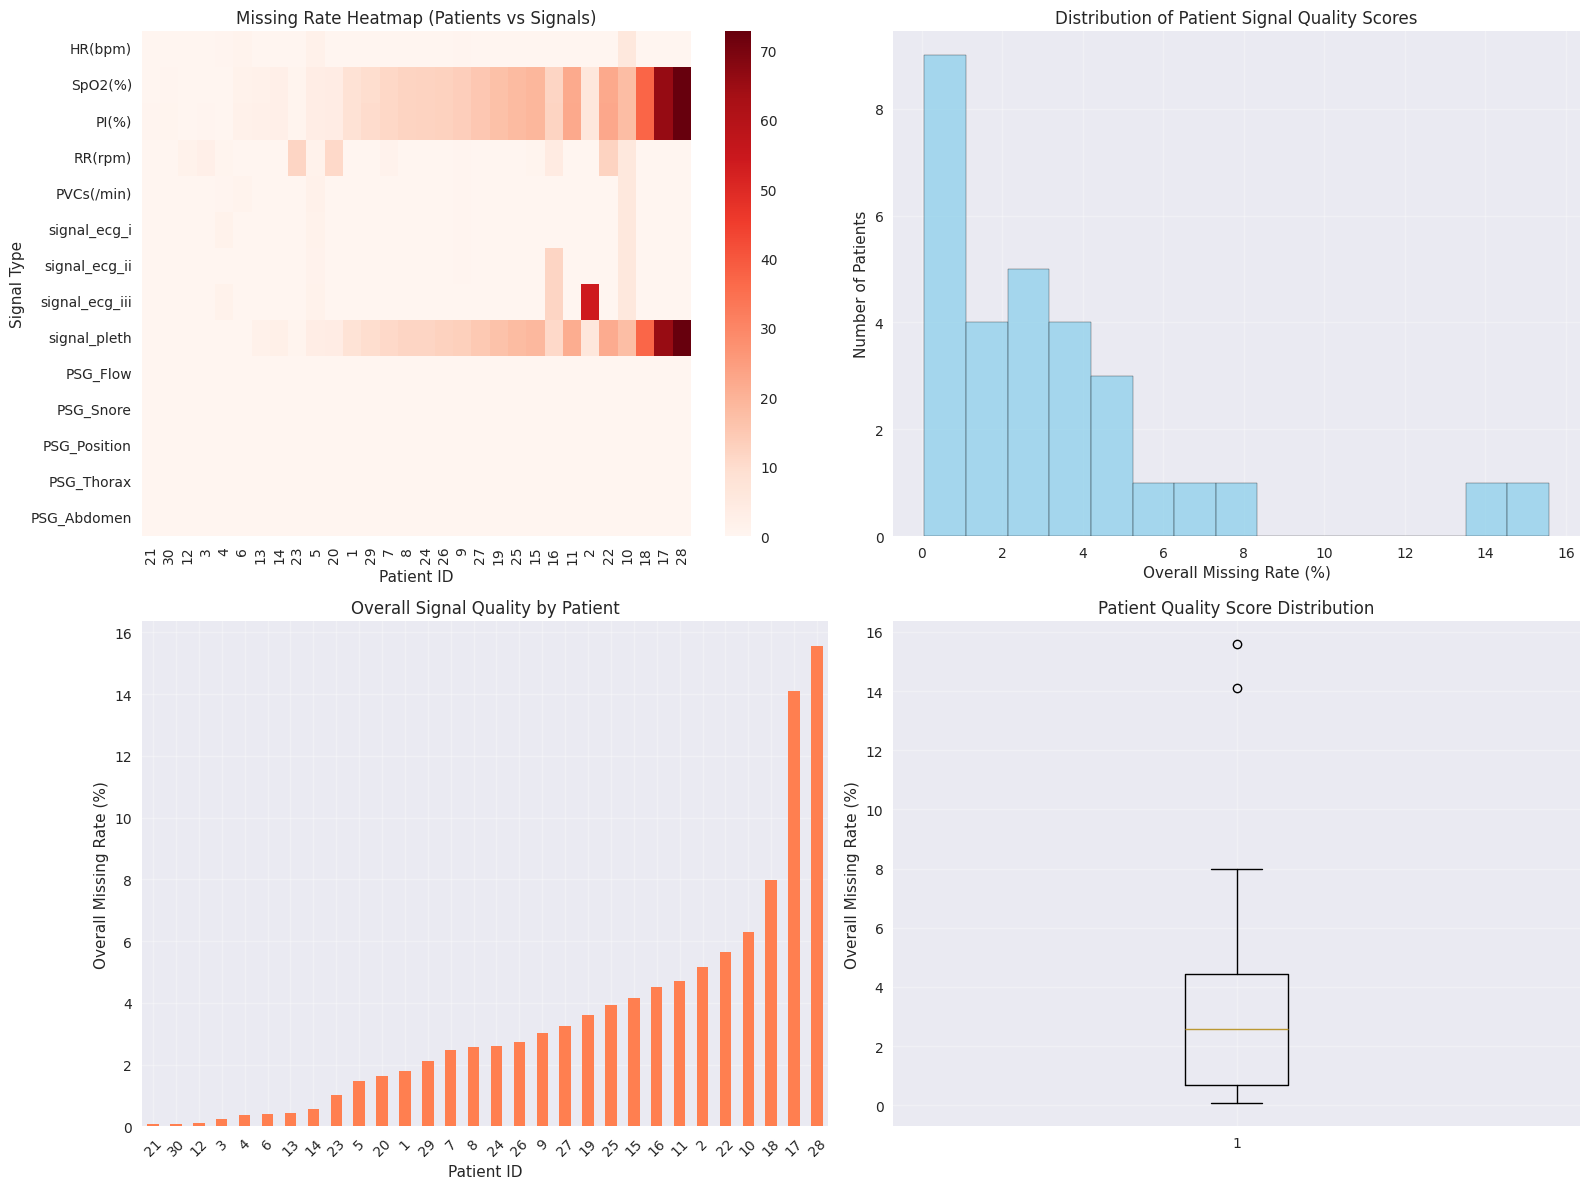

In [7]:
# Visualize patient-wise signal quality
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap of missing rates per patient and signal
sns.heatmap(patient_quality_df.iloc[:, :-1].T, cmap='Reds', annot=False, ax=axes[0,0])
axes[0,0].set_title('Missing Rate Heatmap (Patients vs Signals)')
axes[0,0].set_xlabel('Patient ID')
axes[0,0].set_ylabel('Signal Type')

# Distribution of overall patient quality scores
axes[0,1].hist(patient_quality_df['overall_missing_rate'], bins=15, alpha=0.7, 
               edgecolor='black', color='skyblue')
axes[0,1].set_title('Distribution of Patient Signal Quality Scores')
axes[0,1].set_xlabel('Overall Missing Rate (%)')
axes[0,1].set_ylabel('Number of Patients')
axes[0,1].grid(True, alpha=0.3)

# Bar plot of overall quality per patient
patient_quality_df['overall_missing_rate'].plot(kind='bar', ax=axes[1,0], color='coral')
axes[1,0].set_title('Overall Signal Quality by Patient')
axes[1,0].set_xlabel('Patient ID')
axes[1,0].set_ylabel('Overall Missing Rate (%)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Box plot of quality scores
axes[1,1].boxplot(patient_quality_df['overall_missing_rate'])
axes[1,1].set_title('Patient Quality Score Distribution')
axes[1,1].set_ylabel('Overall Missing Rate (%)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Signal Noise and Artifact Detection

In [8]:
# Analyze signal characteristics for noise detection
def analyze_signal_quality(signal_array):
    """Analyze various quality metrics for a signal array"""
    # First check for None
    if signal_array is None:
        return {}
    
    try:
        # Check if it's a scalar value first (before checking len)
        if np.isscalar(signal_array):
            # For scalar values (vital signs), return basic metrics
            if pd.isna(signal_array):
                return {}
            return {
                'mean': float(signal_array),
                'std': 0.0,
                'range': 0.0,
                'outliers': 0,
                'zero_crossings': 0,
                'snr_estimate': float('inf') if signal_array != 0 else 0.0
            }
        
        # Now check length for array-like objects
        if len(signal_array) == 0:
            return {}
        
        # Handle single-element arrays
        if hasattr(signal_array, '__len__') and len(signal_array) == 1:
            val = signal_array[0]
            return {
                'mean': float(val) if not pd.isna(val) else 0.0,
                'std': 0.0,
                'range': 0.0,
                'outliers': 0,
                'zero_crossings': 0,
                'snr_estimate': float('inf') if val != 0 and not pd.isna(val) else 0.0
            }
        
        # Convert to numpy array for multi-element arrays
        signal_array = np.array(signal_array)
        
        # Remove NaN values
        valid_signal = signal_array[~np.isnan(signal_array)]
        
        if len(valid_signal) == 0:
            return {}
        
        # Calculate quality metrics
        mean_val = np.mean(valid_signal)
        std_val = np.std(valid_signal)
        signal_range = np.ptp(valid_signal)  # peak-to-peak
        
        # Detect outliers using z-score
        if len(valid_signal) > 1 and std_val > 0:
            z_scores = np.abs(zscore(valid_signal))
            outliers = np.sum(z_scores > 3)
        else:
            outliers = 0
        
        # Count zero crossings (sign changes)
        if len(valid_signal) > 1:
            zero_crossings = np.sum(np.diff(np.sign(valid_signal - mean_val)) != 0)
        else:
            zero_crossings = 0
        
        return {
            'mean': mean_val,
            'std': std_val,
            'range': signal_range,
            'outliers': outliers,
            'zero_crossings': zero_crossings,
            'snr_estimate': abs(mean_val) / std_val if std_val > 0 else float('inf')
        }
    except Exception as e:
        return {}

# Analyze vital signs quality
vital_quality = {}
for col in available_vitals:
    if col in dataset.columns:
        signals_quality = []
        for _, row in dataset.head(1000).iterrows():  # Sample for performance
            quality = analyze_signal_quality(row[col])
            if quality:
                signals_quality.append(quality)
        
        if signals_quality:
            # Calculate averages, filtering out infinite values for SNR
            finite_snr_values = [sq['snr_estimate'] for sq in signals_quality 
                                if 'snr_estimate' in sq and np.isfinite(sq['snr_estimate']) and sq['snr_estimate'] != float('inf')]
            
            vital_quality[col] = {
                'avg_std': np.mean([sq['std'] for sq in signals_quality if 'std' in sq]),
                'avg_outliers': np.mean([sq['outliers'] for sq in signals_quality if 'outliers' in sq]),
                'avg_snr': np.mean(finite_snr_values) if finite_snr_values else 0.0,
                'total_samples': len(signals_quality),
                'finite_snr_samples': len(finite_snr_values)
            }

print("VITAL SIGNS QUALITY ANALYSIS:")
print("=" * 40)
for signal, quality in vital_quality.items():
    print(f"{signal}:")
    print(f"  Average Std Dev: {quality['avg_std']:.2f}")
    print(f"  Average Outliers: {quality['avg_outliers']:.1f}")
    print(f"  Average SNR: {quality['avg_snr']:.2f}")
    print(f"  Total samples: {quality['total_samples']}")
    print(f"  Samples with finite SNR: {quality['finite_snr_samples']}")
    print()

VITAL SIGNS QUALITY ANALYSIS:
HR(bpm):
  Average Std Dev: 0.00
  Average Outliers: 0.0
  Average SNR: 0.00
  Total samples: 1000
  Samples with finite SNR: 0

RR(rpm):
  Average Std Dev: 0.00
  Average Outliers: 0.0
  Average SNR: 0.00
  Total samples: 1000
  Samples with finite SNR: 0

PVCs(/min):
  Average Std Dev: 0.00
  Average Outliers: 0.0
  Average SNR: 0.00
  Total samples: 1000
  Samples with finite SNR: 862



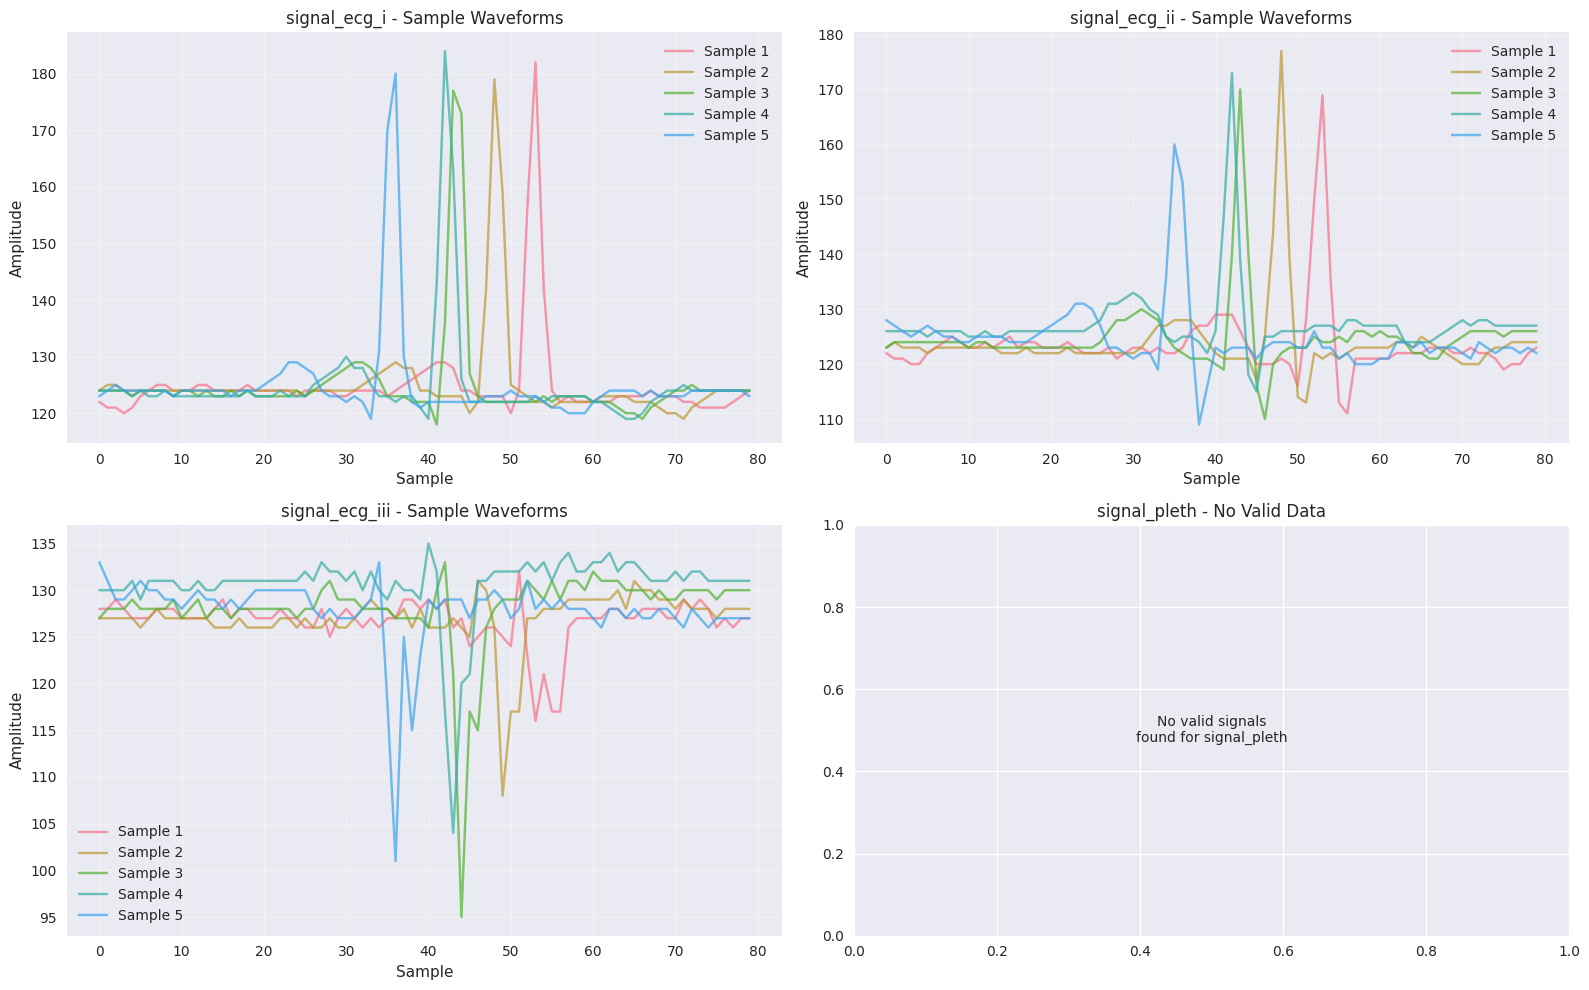

In [ ]:
# Analyze waveform quality (if available)
if available_waveforms:
    # For real data, analyze actual waveforms
    sample_waveforms = dataset[available_waveforms].head(100)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(available_waveforms[:4]):
        if col in sample_waveforms.columns:
            # Plot sample waveforms
            valid_signals = []
            for idx, signal in enumerate(sample_waveforms[col]):
                if signal is not None and not (hasattr(signal, '__len__') and np.all(np.isnan(signal))):
                    try:
                        signal_array = np.array(signal)
                        if len(signal_array) > 0 and not np.all(np.isnan(signal_array)):
                            valid_signals.append(signal_array)
                            if len(valid_signals) >= 5:  # Plot first 5 valid signals
                                break
                    except (TypeError, ValueError):
                        # Skip invalid signals
                        continue
            
            if valid_signals:
                for j, sig in enumerate(valid_signals):
                    axes[i].plot(sig, alpha=0.7, label=f'Sample {j+1}')
                axes[i].set_title(f'{col} - Sample Waveforms')
                axes[i].set_xlabel('Sample')
                axes[i].set_ylabel('Amplitude')
                axes[i].grid(True, alpha=0.3)
                axes[i].legend()
            else:
                axes[i].text(0.5, 0.5, f'No valid signals\nfound for {col}', 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'{col} - No Valid Data')
    
    plt.tight_layout()
    plt.show()

## 4. Identify Problematic Patients

In [10]:
# Define criteria for problematic patients
high_missing_threshold = 20  # % missing data
low_data_threshold = 100     # minimum number of records

# Identify problematic patients
problematic_patients = []
patient_records_count = dataset['patient'].value_counts()

for patient_id in patient_quality_df.index:
    issues = []
    
    # Check missing data rate
    if patient_quality_df.loc[patient_id, 'overall_missing_rate'] > high_missing_threshold:
        issues.append(f"High missing rate ({patient_quality_df.loc[patient_id, 'overall_missing_rate']:.1f}%)")
    
    # Check number of records
    if patient_records_count[patient_id] < low_data_threshold:
        issues.append(f"Low data volume ({patient_records_count[patient_id]} records)")
    
    if issues:
        problematic_patients.append({
            'patient_id': patient_id,
            'issues': issues,
            'missing_rate': patient_quality_df.loc[patient_id, 'overall_missing_rate'],
            'record_count': patient_records_count[patient_id]
        })

print("PROBLEMATIC PATIENTS IDENTIFIED:")
print("=" * 50)
if problematic_patients:
    for patient in problematic_patients:
        print(f"Patient {patient['patient_id']}:")
        for issue in patient['issues']:
            print(f"  - {issue}")
        print()
else:
    print("No problematic patients identified based on current criteria.")

print(f"\nSUMMARY:")
print(f"Total patients: {len(patient_quality_df)}")
print(f"Problematic patients: {len(problematic_patients)}")
print(f"Good quality patients: {len(patient_quality_df) - len(problematic_patients)}")

PROBLEMATIC PATIENTS IDENTIFIED:
No problematic patients identified based on current criteria.

SUMMARY:
Total patients: 30
Problematic patients: 0
Good quality patients: 30


## 5. Signal Quality Recommendations

In [11]:
# Generate recommendations based on signal quality analysis
recommendations = []

# Check overall missing rates
avg_missing_rate = patient_quality_df['overall_missing_rate'].mean()
if avg_missing_rate > 10:
    recommendations.append("High overall missing data rate - consider imputation strategies")

# Check for signals with consistently high missing rates
high_missing_signals = missing_df[missing_df['Missing_Rate_%'] > 15]['Signal'].tolist()
if high_missing_signals:
    recommendations.append(f"Consider excluding high-missing signals: {high_missing_signals}")

# Check patient variability
patient_quality_std = patient_quality_df['overall_missing_rate'].std()
if patient_quality_std > 10:
    recommendations.append("High variability in patient signal quality - consider patient-specific preprocessing")

# Check for problematic patients
if len(problematic_patients) > 0:
    recommendations.append(f"Consider excluding {len(problematic_patients)} problematic patients from analysis")

print("SIGNAL QUALITY RECOMMENDATIONS:")
print("=" * 50)
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

if not recommendations:
    print("Signal quality appears to be good overall - no specific recommendations.")

print("\nGENERAL PREPROCESSING RECOMMENDATIONS:")
print("=" * 50)
print("1. Apply bandpass filtering (5-35 Hz) to ECG and PPG signals")
print("2. Implement outlier detection and removal")
print("3. Use interpolation for short missing segments (<5 seconds)")
print("4. Exclude windows with >50% missing data")
print("5. Normalize signals per-patient to account for individual differences")
print("6. Consider quality scores when weighting samples during training")

SIGNAL QUALITY RECOMMENDATIONS:
Signal quality appears to be good overall - no specific recommendations.

GENERAL PREPROCESSING RECOMMENDATIONS:
1. Apply bandpass filtering (5-35 Hz) to ECG and PPG signals
2. Implement outlier detection and removal
3. Use interpolation for short missing segments (<5 seconds)
4. Exclude windows with >50% missing data
5. Normalize signals per-patient to account for individual differences
6. Consider quality scores when weighting samples during training


## 6. Signal Quality Summary Statistics

In [12]:
# Create comprehensive summary
print("=" * 60)
print("SIGNAL QUALITY ANALYSIS SUMMARY")
print("=" * 60)

print(f"\nOVERALL STATISTICS:")
print(f"  Total signals analyzed: {len(all_signal_columns)}")
print(f"  Average missing rate across all signals: {missing_df['Missing_Rate_%'].mean():.1f}%")
print(f"  Median missing rate: {missing_df['Missing_Rate_%'].median():.1f}%")
print(f"  Worst signal missing rate: {missing_df['Missing_Rate_%'].max():.1f}%")
print(f"  Best signal missing rate: {missing_df['Missing_Rate_%'].min():.1f}%")

print(f"\nPATIENT QUALITY DISTRIBUTION:")
print(f"  Average patient missing rate: {patient_quality_df['overall_missing_rate'].mean():.1f}%")
print(f"  Best patient missing rate: {patient_quality_df['overall_missing_rate'].min():.1f}%")
print(f"  Worst patient missing rate: {patient_quality_df['overall_missing_rate'].max():.1f}%")
print(f"  Standard deviation: {patient_quality_df['overall_missing_rate'].std():.1f}%")

print(f"\nSIGNAL CATEGORIES:")
print(f"  High quality signals (< 5% missing): {len(high_quality)}")
print(f"  Medium quality signals (5-15% missing): {len(medium_quality)}")
print(f"  Low quality signals (> 15% missing): {len(low_quality)}")

print(f"\nPROBLEMATIC CASES:")
print(f"  Problematic patients identified: {len(problematic_patients)}")
print(f"  Percentage of problematic patients: {len(problematic_patients)/len(patient_quality_df)*100:.1f}%")

print(f"\nRECOMMENDED ACTIONS:")
if len(problematic_patients) > 0:
    print(f"  Consider excluding patients: {[p['patient_id'] for p in problematic_patients]}")
if high_missing_signals:
    print(f"  Consider excluding signals: {high_missing_signals}")
print(f"  Implement robust preprocessing pipeline with quality checks")
print(f"  Use signal quality scores for sample weighting during training")

SIGNAL QUALITY ANALYSIS SUMMARY

OVERALL STATISTICS:
  Total signals analyzed: 14
  Average missing rate across all signals: 3.4%
  Median missing rate: 0.4%
  Worst signal missing rate: 13.9%
  Best signal missing rate: 0.0%

PATIENT QUALITY DISTRIBUTION:
  Average patient missing rate: 3.4%
  Best patient missing rate: 0.1%
  Worst patient missing rate: 15.6%
  Standard deviation: 3.7%

SIGNAL CATEGORIES:
  High quality signals (< 5% missing): 11
  Medium quality signals (5-15% missing): 3
  Low quality signals (> 15% missing): 0

PROBLEMATIC CASES:
  Problematic patients identified: 0
  Percentage of problematic patients: 0.0%

RECOMMENDED ACTIONS:
  Implement robust preprocessing pipeline with quality checks
  Use signal quality scores for sample weighting during training


## Conclusions

### Key Findings:

1. **Signal Completeness**: Varies significantly across signal types and patients
2. **Patient Variability**: Some patients have consistently poor signal quality
3. **Signal Types**: Different modalities (ECG, PPG, PSG) may have different quality profiles

### Preprocessing Strategy:

1. **Quality Filtering**: Exclude windows with >50% missing data
2. **Patient Screening**: Consider excluding patients with consistently poor signal quality
3. **Signal Processing**: Apply appropriate filtering and artifact removal
4. **Imputation**: Use interpolation for short missing segments
5. **Normalization**: Apply per-patient normalization to account for individual differences

### Next Steps:
- Proceed to label alignment analysis
- Implement the preprocessing pipeline
- Design quality-aware model training strategy